In [1]:
from Annotation_helper import *
import numpy as np
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
# from sklearnex import patch_sklearn 

# patch_sklearn()

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Helper functions

In [4]:
# def plot_metrics(history):
#   metrics = ['loss', 'prc', 'precision', 'recall']
#   for n, metric in enumerate(metrics):
#     name = metric.replace("_"," ").capitalize()
#     plt.subplot(2,2,n+1)
#     plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
#     plt.plot(history.epoch, history.history['val_'+metric],
#              color=colors[0], linestyle="--", label='Val')
#     plt.xlabel('Epoch')
#     plt.ylabel(name)
#     if metric == 'loss':
#       plt.ylim([0, plt.ylim()[1]])
#     elif metric == 'auc':
#       plt.ylim([0.8,1])
#     else:
#       plt.ylim([0,1])

#     plt.legend();

In [5]:
# def evaluate_prediction(pred, y_true, model_name="default_model"):
#     cm = confusion_matrix(y_true, pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot()
#     plt.savefig(f"{figure_folder}_{model_name}_Confusion_matrix.png")
#     plt.show()
#     print("recall score: ", recall_score(y_true, pred))
#     print("precision score: ", precision_score(y_true, pred))
#     print("f1 score: ", f1_score(y_true, pred))

# def fit_and_test_classifier(clf, X_train, y_train, y_true, model_name="default_model"):
#     clf = clf.fit(X_train, y_train)
#     pred = clf.predict(X_test)
    
#     evaluate_prediction(pred, y_true, model_name)
    
#     display = PrecisionRecallDisplay.from_estimator(
#         clf, X_test, y_test, name=model_name
#     )
#     _ = display.ax_.set_title("2-class Precision-Recall curve")
    
#     plt.savefig(f"{figure_folder}_{model_name}_PR_curve.png")
#     return clf

In [6]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Loading data

In [7]:
matches = pd.read_csv("Matches/Bas3.csv", index_col=0)
# dist_folder = "Distances_levenshtein"
dist_folder = "filtered_Distances"
figure_folder = "../Figures/Results/Classic"

In [8]:
distances = pd.read_csv(dist_folder + "/distances_0.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
for i in range(1, 99):
    df2 = pd.read_csv(f"{dist_folder}/distances_{i}.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
    distances = pd.concat([distances, df2])
distances.reset_index(inplace=True)

In [9]:
len(matches[matches['transaction_indx'] != 'None']["permission_indx"].unique())

60

In [10]:
matches[matches['transaction_indx'] != 'None']

,Annotator,transaction_indx,permission_indx
30,Bas,4097,32
31,Bas,4242,33
32,Bas,4242,33
33,Bas,4228,34
37,Bas,4220,38
...,...,...,...
364,Bas,2808,353
365,Bas,4313,353
366,Bas,4257,354
367,Bas,4312,354


In [11]:
distances

,index,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterTussen,BezitterAchternaam,BezitterBeroep,BezitterStatus,BezitterEtniciteit
0,0,0,0,True,0.000000,False,0.000000,0.0,0.000000,0.0,0.0,0.0
1,1,0,1,True,0.250000,False,0.000000,0.0,0.000000,0.0,0.0,0.0
2,2,0,2,False,0.166626,False,0.000000,0.0,0.000000,0.0,0.0,0.0
3,3,0,3,True,0.111084,False,0.000000,0.0,0.000000,0.0,0.0,0.0
4,4,0,4,True,0.142822,False,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26638723,265951,3889,7192,True,0.250000,True,0.166626,0.0,0.166626,0.0,0.0,1.0
26638724,265952,3889,7193,False,0.250000,True,0.166626,0.0,0.166626,0.0,0.0,1.0
26638725,265953,3889,7194,False,0.000000,True,0.277832,0.0,0.000000,0.0,0.0,1.0
26638726,265954,3889,7195,False,0.000000,True,0.166626,0.0,0.166626,0.0,0.0,1.0


In [12]:
all_data = distances[distances['permission_indx'].isin(matches["permission_indx"].unique())]
all_data["Match"] = 0
for i, match in matches.iterrows():
    if match["transaction_indx"] != "None":
        indx = distances.query(f"permission_indx == {match['permission_indx']} & transaction_indx == {match['transaction_indx']}").index
        all_data.loc[indx, "Match"] = 1
data = all_data.iloc[:, 3:-1]
y = all_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

<ipython-input-12-e521af8c2916>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data["Match"] = 0
C:\Users\basvd\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [13]:
d = distances
d = d[d["SlaafNaamNieuw"] > 0.3]
d = d[d["SlaafGender"] > 0.3]
d = d[d["BezitterAchternaam"] > 0.1]
d = d[d["BezitterVoornaam"] > 0.6]
d

,index,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterTussen,BezitterAchternaam,BezitterBeroep,BezitterStatus,BezitterEtniciteit
173655,173655,24,1143,True,0.600098,True,1.000000,0.0,0.142822,0.000000,0.0,0.0
185629,185629,26,5933,True,1.000000,True,0.799805,0.0,0.142822,0.000000,0.0,0.0
196131,196131,28,2057,True,0.555664,True,1.000000,0.0,0.199951,0.199951,0.0,0.0
203319,203319,29,2057,True,0.555664,True,1.000000,0.0,0.199951,0.199951,0.0,0.0
216328,216328,31,688,True,1.000000,True,0.636230,0.0,0.142822,0.115356,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26591775,219003,3883,3365,True,0.399902,True,1.000000,0.0,0.272705,0.125000,0.0,0.0
26598762,225990,3884,3164,True,1.000000,True,0.866699,0.0,0.500000,0.000000,0.0,0.0
26598809,226037,3884,3211,True,0.399902,True,0.866699,0.0,0.500000,0.000000,0.0,0.0
26600335,227563,3884,4738,True,0.333252,True,0.866699,0.0,0.500000,0.000000,0.0,0.0


In [14]:
all_data[all_data["Match"] == 0]

,index,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterTussen,BezitterAchternaam,BezitterBeroep,BezitterStatus,BezitterEtniciteit,Match
0,0,0,0,True,0.000000,False,0.000000,0.0,0.0,0.0,0.000000,0.0,0
1,1,0,1,True,0.250000,False,0.000000,0.0,0.0,0.0,0.000000,0.0,0
2,2,0,2,False,0.166626,False,0.000000,0.0,0.0,0.0,0.000000,0.0,0
3,3,0,3,True,0.111084,False,0.000000,0.0,0.0,0.0,0.000000,0.0,0
4,4,0,4,True,0.142822,False,0.000000,0.0,0.0,0.0,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695495,237199,375,7192,True,0.166626,True,0.142822,0.0,0.0,0.0,0.090909,0.0,0
2695496,237200,375,7193,False,0.000000,True,0.142822,0.0,0.0,0.0,0.090909,0.0,0
2695497,237201,375,7194,False,0.000000,True,0.142822,0.0,0.0,0.0,0.090909,0.0,0
2695498,237202,375,7195,False,0.111084,True,0.125000,0.0,0.0,0.0,0.090909,0.0,0


In [15]:
all_data[all_data["Match"] == 1]

,index,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterTussen,BezitterAchternaam,BezitterBeroep,BezitterStatus,BezitterEtniciteit,Match
226923,226923,32,4097,True,0.856934,True,0.769043,0.0,1.000000,0.884766,0.0,0.0,1
234255,234255,33,4242,True,1.000000,True,0.916504,0.0,1.000000,0.884766,0.0,0.0,1
241429,241429,34,4228,True,0.428467,True,0.846191,0.0,1.000000,0.307617,0.0,0.0,1
270173,270173,38,4220,True,0.777832,True,0.888672,0.0,0.714355,1.000000,0.0,0.0,1
284531,11387,40,4202,True,1.000000,True,1.000000,0.0,0.856934,1.000000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2532982,74686,353,2808,True,1.000000,True,1.000000,0.0,1.000000,1.000000,0.0,0.0,1
2534486,76190,353,4313,True,1.000000,True,1.000000,0.0,1.000000,1.000000,0.0,0.0,1
2541618,83322,354,4257,True,1.000000,True,0.909180,0.0,1.000000,1.000000,0.0,0.0,1
2541673,83377,354,4312,True,1.000000,True,1.000000,0.0,1.000000,1.000000,0.0,0.0,1


In [16]:
all_data

,index,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterTussen,BezitterAchternaam,BezitterBeroep,BezitterStatus,BezitterEtniciteit,Match
0,0,0,0,True,0.000000,False,0.000000,0.0,0.0,0.0,0.000000,0.0,0
1,1,0,1,True,0.250000,False,0.000000,0.0,0.0,0.0,0.000000,0.0,0
2,2,0,2,False,0.166626,False,0.000000,0.0,0.0,0.0,0.000000,0.0,0
3,3,0,3,True,0.111084,False,0.000000,0.0,0.0,0.0,0.000000,0.0,0
4,4,0,4,True,0.142822,False,0.000000,0.0,0.0,0.0,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695495,237199,375,7192,True,0.166626,True,0.142822,0.0,0.0,0.0,0.090909,0.0,0
2695496,237200,375,7193,False,0.000000,True,0.142822,0.0,0.0,0.0,0.090909,0.0,0
2695497,237201,375,7194,False,0.000000,True,0.142822,0.0,0.0,0.0,0.090909,0.0,0
2695498,237202,375,7195,False,0.111084,True,0.125000,0.0,0.0,0.0,0.090909,0.0,0


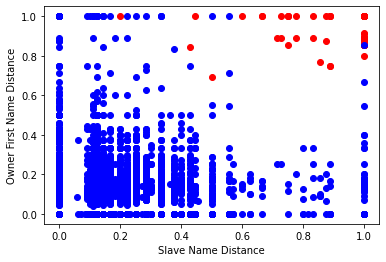

In [17]:
sample1 = all_data[all_data["Match"] == 1].sample(68)
plt.scatter(sample1["SlaafNaamNieuw"], sample1["BezitterVoornaam"], color="r")
sample2 = all_data[all_data["Match"] == 0].sample(5000)
plt.scatter(sample2["SlaafNaamNieuw"], sample2["BezitterVoornaam"], color="b")
plt.xlabel("Slave Name Distance")
plt.ylabel("Owner First Name Distance")

plt.show()

In [18]:
y

0          0
1          0
2          0
3          0
4          0
          ..
2695495    0
2695496    0
2695497    0
2695498    0
2695499    0
Name: Match, Length: 2688312, dtype: int64

In [19]:
sample = pd.concat([sample1, sample2])
y = sample["Match"]

In [20]:
def plot_decision_boundary(X, y, model, model_name="Default_model", ax_labels=('x', 'y'), colors = ("b", "r"), labels=("non-matches", "matches")):
    clf = model.fit(X, y)

    fig, ax = plt.subplots()
    # title for the plots
    title = (f'Decision surface of {model_name}')
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    for i in range(0, 2):
        mask = (y == i)
        tX = X[mask]
        ty = y[mask]
        X0, X1 = tX[:, 0], tX[:, 1]
        ax.scatter(X0, X1, c=colors[i], s=20, edgecolors='k', label=labels[i])
    ax.set_ylabel(f'Owner {ax_labels[1]} similarity')
    ax.set_xlabel(f'{ax_labels[0]} similarity')

    ax.set_title(title)
    ax.legend()
    plt.savefig(figure_folder + f"Decision_boundary_{model_name}.png")
    plt.show()

In [21]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

X = sample.iloc[:, 3:-1][["SlaafNaamNieuw", "BezitterVoornaam"]].values

# model = svm.SVC(kernel='linear')
# model = KNeighborsClassifier(n_neighbors=1)
# model = make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(30, 30), learning_rate='adaptive', random_state=1, verbose=False))
# model = make_pipeline(StandardScaler(),svm.SVC())
# model = AdaBoostClassifier(n_estimators=100, random_state=0)

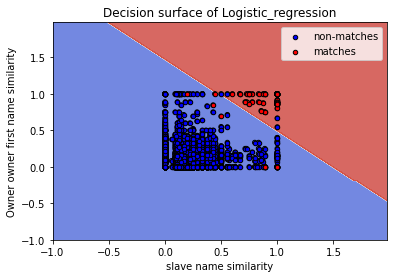

In [22]:
plot_decision_boundary(X, y, make_pipeline(StandardScaler(), LogisticRegression()), "Logistic_regression", ("slave name", "owner first name"))

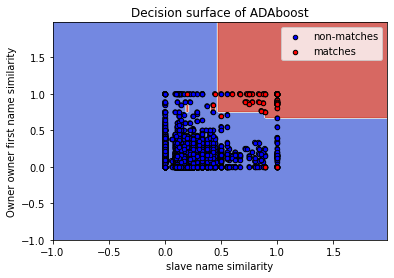

In [23]:
plot_decision_boundary(X, y, make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=30, random_state=0)), "ADAboost", ("slave name", "owner first name"))

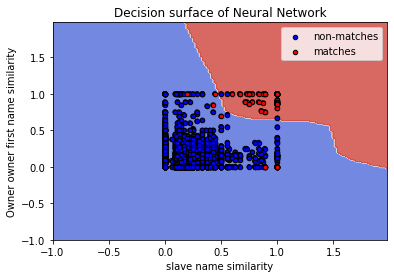

In [24]:
plot_decision_boundary(X, y, make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(30, 30), learning_rate='adaptive', random_state=1, verbose=False)), "Neural Network", ("slave name", "owner first name"))

In [25]:
sample = pd.concat([sample1, sample2])
y = sample["Match"]

In [26]:
clf = LogisticRegression().fit(sample[["SlaafNaamNieuw", "BezitterVoornaam"]], sample["Match"])

In [27]:
clf.predict(sample[["SlaafNaamNieuw", "BezitterVoornaam"]])

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [28]:
y_train

1143156    0
556077     0
1180356    0
421248     0
1155921    0
          ..
110268     0
1699931    0
2363518    0
2236272    0
2226298    0
Name: Match, Length: 1881818, dtype: int64

In [29]:
Classifiers = dict()

# Normalizing data

In [30]:
print("X: ", X_train.shape)
print("y: ", y_train.shape)

X:  (1881818, 9)
y:  (1881818,)


# Blocking

In [31]:
print(f"{X_train.shape[0]} rows before blocking")

1881818 rows before blocking


In [32]:
mask = (X_train["SlaafNaamNieuw"] > 0.3) & (X_train["SlaafGender"] > 0.1) & (X_train["BezitterAchternaam"] > 0.1) & (X_train["BezitterVoornaam"] > 0.1)

In [33]:
X_train = X_train[mask]
y_train = y_train[mask]

In [34]:
# d = distances
# d = d[d["SlaafNaamNieuw"] > 0.3]
# d = d[d["SlaafGender"] > 0.3]
# d = d[d["BezitterAchternaam"] > 0.1]
# d = d[d["BezitterVoornaam"] > 0.1]
# distances = d

In [35]:
print(f"{X_train.shape[0]} rows after blocking")

40961 rows after blocking


# Oversampling

In [36]:
np.where(y_train == 1)

(array([ 1554,  1826,  3794,  6825,  8699,  8731,  9889, 10000, 10003,
        11629, 11715, 12759, 14888, 16267, 16609, 17828, 17908, 19036,
        20516, 20851, 24771, 25549, 25657, 25827, 28885, 32912, 36702,
        37023, 37267, 38160, 39217, 39505], dtype=int64),)

In [37]:
# ros = RandomUnderSampler()
# X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)

In [38]:
X_train = X_train.to_numpy().astype(float)
y_train = y_train.to_numpy().astype(float)

X_test = X_test.to_numpy().astype(float)
y_test = y_test.to_numpy().astype(float)

# Rule based

In [39]:
class Rule_based_classifier():
    def __init__(self, alg):
        self.alg = alg
        
    def predict_proba(self, X_test):
        pred = self.alg(X_test)
        return pred
    
    def predict(self, X_test, thresh):
        pred = self.alg(X_test)
        return (pred >= thresh).astype(float)

## Exact match

In [40]:
def exact_match(X_test):
    pred = []
    for x in X_test:
        pred.append((x == 1.).sum())
    return np.array(pred)/X_test.shape[1]

In [41]:
EM = Rule_based_classifier(exact_match)
pred = EM.predict(X_test, 0.5)

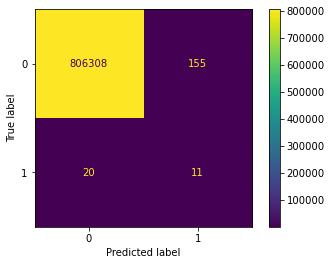

recall score:  0.3548387096774194
precision score:  0.06626506024096386
f1 score:  0.11167512690355332


In [42]:
evaluate_prediction(pred, y_test, model_name = "Exact Match")

In [43]:
Classifiers["Exact Match"] = EM

# Fuzzy match

In [44]:
def fuzzy_match(X_test):
    pred = []
    for x in X_test:
        pred.append((x > 0.1).sum())
    return np.array(pred)/X_test.shape[1]

In [45]:
FM = Rule_based_classifier(fuzzy_match)
pred = FM.predict(X_test, 1.)

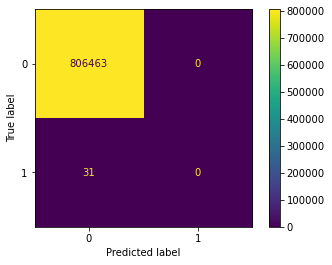

recall score:  0.0


C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision score:  0.0
f1 score:  0.0


In [46]:
evaluate_prediction(pred, y_test, model_name = "Fuzzy Match")

In [47]:
Classifiers["Fuzzy Match"] = FM

# All 0

In [48]:
pred = np.zeros(len(y_test))
pred

array([0., 0., 0., ..., 0., 0., 0.])

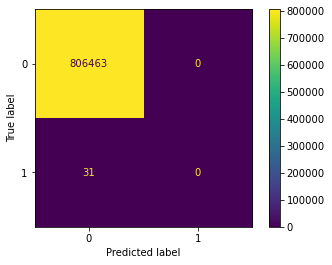

recall score:  0.0


C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision score:  0.0
f1 score:  0.0


In [49]:
evaluate_prediction(pred, y_test, model_name="All 0")

# K nearest neighbors

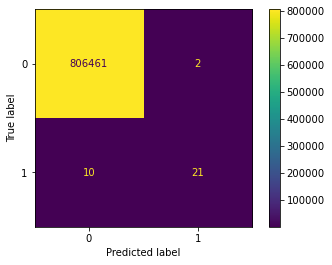

recall score:  0.6774193548387096
precision score:  0.9130434782608695
f1 score:  0.7777777777777777


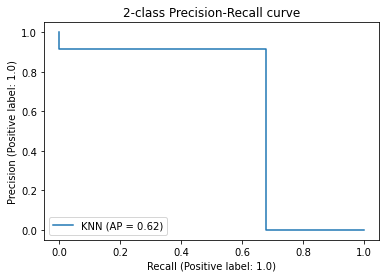

In [50]:
from sklearn.neighbors import KNeighborsClassifier
KNNClf = fit_and_test_classifier(KNeighborsClassifier(n_neighbors=1), X_train, X_test, y_train, y_test, model_name="KNN", figure_folder=figure_folder)

Classifiers["KNeigbors classifier"] = KNNClf

# Logistic regression

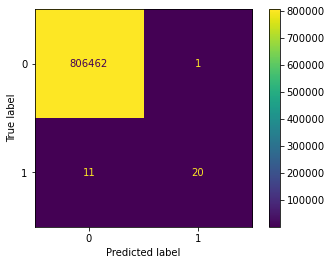

recall score:  0.6451612903225806
precision score:  0.9523809523809523
f1 score:  0.7692307692307692


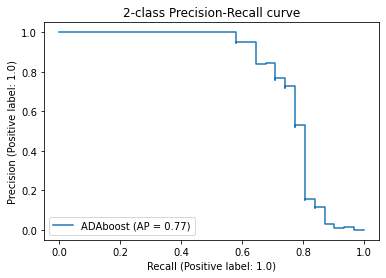

In [51]:
est = make_pipeline(StandardScaler(),AdaBoostClassifier(n_estimators=30, random_state=0))
LGClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="ADAboost", figure_folder=figure_folder)

Classifiers["Logistic Regression"] = LGClf

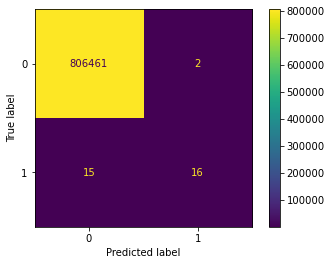

recall score:  0.5161290322580645
precision score:  0.8888888888888888
f1 score:  0.6530612244897959


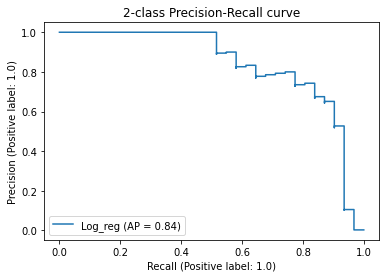

In [52]:
est = make_pipeline(StandardScaler(), LogisticRegression())
LGClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="Log_reg", figure_folder=figure_folder)

Classifiers["Logistic Regression"] = LGClf

In [53]:
LGClf.steps[1][1].coef_

array([[ 0.        ,  2.59744965,  0.1965662 ,  0.88618936,  0.11568327,
         0.65890996,  0.52320332,  0.48134031, -0.05626728]])

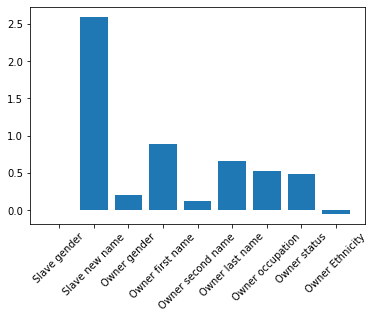

In [54]:
fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
langs = data.columns
langs = ["Slave gender", "Slave new name", "Owner gender", "Owner first name", "Owner second name", "Owner last name", "Owner occupation", "Owner status", "Owner Ethnicity"]
students = LGClf.steps[1][1].coef_[0]
plt.bar(langs,students)
plt.xticks(rotation = 45)
plt.savefig(figure_folder + "Coefs.jpg")
plt.show()

In [55]:
data.columns

Index(['SlaafGender', 'SlaafNaamNieuw', 'BezitterGender', 'BezitterVoornaam',
       'BezitterTussen', 'BezitterAchternaam', 'BezitterBeroep',
       'BezitterStatus', 'BezitterEtniciteit'],
      dtype='object')

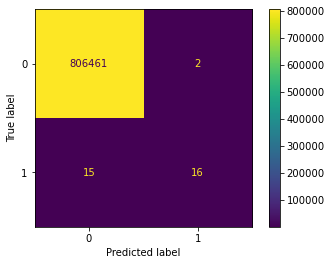

recall score:  0.5161290322580645
precision score:  0.8888888888888888
f1 score:  0.6530612244897959


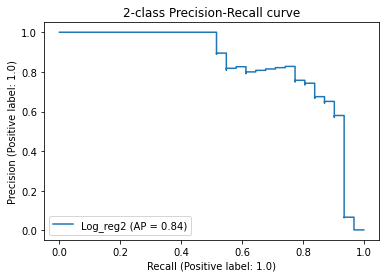

In [56]:
from sklearn.linear_model import LogisticRegressionCV

est = make_pipeline(StandardScaler(), LogisticRegressionCV(scoring='f1'))
LGClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="Log_reg2", figure_folder=figure_folder)

Classifiers["Logistic Regression"] = LGClf

# Naive Bayes

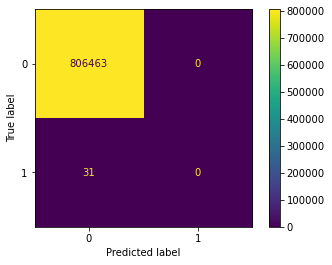

recall score:  0.0


C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision score:  0.0
f1 score:  0.0


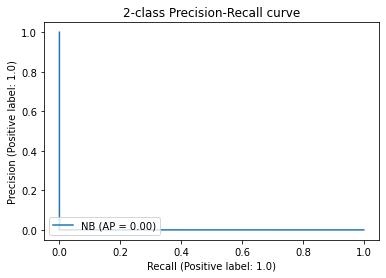

In [57]:
from sklearn.naive_bayes import MultinomialNB

est = make_pipeline(Normalizer(), MultinomialNB())
NBClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="NB", figure_folder=figure_folder)

Classifiers["Naive Bayes"] = NBClf

# SVM

In [58]:
# from sklearn.svm import SVC
# fit_and_test_classifier(SVC(gamma=2, C=1), X_train, y_train, y_test)

# New technique

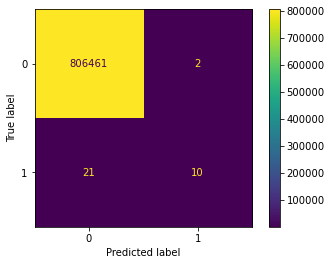

recall score:  0.3225806451612903
precision score:  0.8333333333333334
f1 score:  0.4651162790697674


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(loss='perceptron'))])

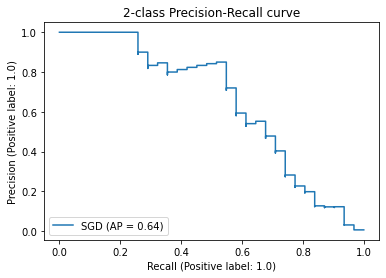

In [59]:
from sklearn.linear_model import SGDClassifier
est = make_pipeline(StandardScaler(), SGDClassifier(loss='perceptron'))

fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="SGD", figure_folder=figure_folder)

In [60]:
X_train[0]

array([1.        , 0.33325195, 0.        , 0.22216797, 0.        ,
       0.11108398, 0.        , 0.        , 0.        ])

# Evaluating results

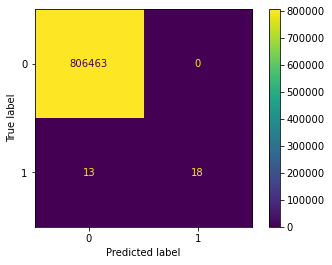

recall score:  0.5806451612903226
precision score:  1.0
f1 score:  0.7346938775510204


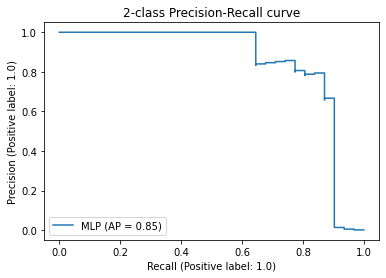

In [61]:
est = make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(30, 30), learning_rate='adaptive', random_state=1, verbose=False))

NNClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="MLP", figure_folder=figure_folder)
Classifiers["Neural network"] = NNClf

# Tensorflow

In [62]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_transform as tft

tf.compat.v1.disable_eager_execution()

In [63]:
# model = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(X_train.shape[-1]),
#     tf.keras.layers.Dense(3, activation='relu'),
#     tf.keras.layers.Dense(3, activation='relu'),
#     tf.keras.layers.Dense(3, activation='relu'),
#     tf.keras.layers.Dense(1, activation='softmax'),
# ])

In [64]:
# model.compile("adam", loss='binary_crossentropy', metrics=["Accuracy"])

In [65]:
# model.fit(X_train, tft.scale_to_0_1(y_train), steps_per_epoch=10)

In [66]:
# est = make_pipeline(StandardScaler(), model)

# fit_and_test_classifier(est, X_train, y_train, y_test)

In [67]:
# model.fit(X_train, y_train, batch_size = 128)

In [68]:
# pred = model.predict(X_test)
# cm = confusion_matrix(y_test, pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()

In [69]:
# roc curve and auc on an imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [70]:
# from sklearn.linear_model import LogisticRegression

# model = make_pipeline(StandardScaler(), LogisticRegression())
# model = fit_and_test_classifier(model, X_train, y_train, y_test)

In [ ]:
for name in Classifiers:
    model = Classifiers[name]
#     print("name:", name)
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
#     print("lr_probs", lr_probs)
    if type(lr_probs[0]) == np.ndarray:
        lr_probs = lr_probs[:, 1]
    # calculate scores
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print(name + ': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label=name)
    
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
print('No Skill: ROC AUC=%.3f' % (ns_auc))

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Exact Match: ROC AUC=0.978
Fuzzy Match: ROC AUC=0.946
